# Approfondissement ElasticSearch pour des recherches de proximité

géographique

Pour essayer les exemples présents dans ce tutoriel :

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modern-ds/elastic_approfondissement.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter.png)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modern-ds/elastic_approfondissement.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter.png)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/modern-ds/elastic_approfondissement.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python.png)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABnotebooks/course/modern-ds%20elastic_approfondissement.ipynb%C2%BB&security.allowlist.enabled=false)<br>
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=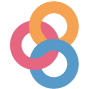.png)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=notebooks/course/modern-ds/elastic_approfondissement.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/modern-ds/elastic_approfondissement.ipynb)
[![githubdev](https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc.png)](https://github.dev/linogaliana/python-datascientist/notebooks/course/modern-ds/elastic_approfondissement.ipynb)

Ce chapitre est issu du travail produit
dans le cadre d’un hackathon de l’Insee avec
[Raphaële Adjerad](https://github.com/raphaeleadjerad)
et présente quelques éléments qui peuvent être utiles
pour l’enrichissement de données d’entreprises
à partir d’un répertoire officiel.

:warning: Il nécessite une version particulière du package `elasticsearch` pour tenir compte de l’héritage de la version 7 du moteur Elastic. Pour cela, faire

``` python
pip install elasticsearch==8.2.0
```

# Introduction

## Objectif

Ce chapitre vise à approfondir les éléments présentés sur Elastic précédemment. L’idée
est de se placer dans un contexte opérationnel où on reçoit des informations
sur des entreprises telles que l’adresse et la localisation et qu’on
désire associer à des données administratives considérées plus fliables.

## Réplication de ce chapitre

Comme le précédent, ce chapitre est plus exigeant en termes d’infrastructures que les précédents.
Il nécessite un serveur Elastic. Les utilisateurs du
[SSP Cloud](datalab.sspcloud.fr/) pourront répliquer les exemples de ce cours
car cette technologie est disponible (que ce soit pour indexer une base ou
pour requêter une base existante).

La première partie de ce tutoriel, qui consiste à créer une base Sirene géolocalisée
à partir des données *open-data* ne nécessite pas d’architecture particulière et
peut ainsi être exécutée en utilisant les packages suivants:

In [2]:
import time
import numpy as np
import pandas as pd

## Sources

Ce chapitre va utiliser plusieurs sources de diffusion de
l’Insee:

-   Le stock des établissements présents dans les [données de diffusion Sirene](https://www.insee.fr/fr/information/3591226) ;
-   Les [données Sirene géolocalisées](https://www.data.gouv.fr/fr/datasets/geolocalisation-des-etablissements-du-repertoire-sirene-pour-les-etudes-statistiques/)

# Constitution du référentiel administratif géolocalisé

Dans un premier temps, on va combiner ensemble les différentes sources
*open-data* pour créer un référentiel fiable d’entreprises
géolocalisées.

## Importer la base déjà créée

Les données à utiliser pour constuire une base Sirene géolocalisée
sont trop volumineuses pour les serveurs mis à disposition
gratuitement par `Github` pour la compilation de ce site web.
Nous proposons ainsi une version déjà construite, stockée
dans l’espace de mise à disposition du SSP Cloud. Ce fichier est
au format `parquet` et est ouvert à
tous, même pour les personnes ne disposant pas d’un compte.
Le code ayant construit cette base est présenté ci-dessous.

Pour importer cette base

## Reproduire la construction de la base

La première base d’entrée à utiliser est disponible sur
[data.gouv](https://www.data.gouv.fr/fr/datasets/base-sirene-des-entreprises-et-de-leurs-etablissements-siren-siret/)

In [3]:
import requests
import zipfile

url_download = "https://www.data.gouv.fr/fr/datasets/r/0651fb76-bcf3-4f6a-a38d-bc04fa708576"
req = requests.get(url_download)

with open("sirene.zip",'wb') as f:
  f.write(req.content)

with zipfile.ZipFile("sirene.zip", 'r') as zip_ref:
  zip_ref.extractall("sirene")

On va importer seulement les colonnes utiles et simplifier la structure
pour être en mesure de ne garder que les informations qui nous
intéressent (nom de l’entreprise, adresse, commune, code postal…)

In [4]:
import pandas as pd
import numpy as np

list_cols = [
  'siren', 'siret',
  'activitePrincipaleRegistreMetiersEtablissement',
  'complementAdresseEtablissement',
  'numeroVoieEtablissement',
  'typeVoieEtablissement',
  'libelleVoieEtablissement',
  'codePostalEtablissement',
  'libelleCommuneEtablissement',
  'codeCommuneEtablissement',
  'etatAdministratifEtablissement',
  'denominationUsuelleEtablissement',
  'activitePrincipaleEtablissement'
]

df = pd.read_csv(
  "sirene/StockEtablissement_utf8.csv",
  usecols = list_cols)

df['numero'] = df['numeroVoieEtablissement']\
  .replace('-', np.NaN).str.split().str[0]\
  .str.extract('(\d+)', expand=False)\
  .fillna("0").astype(int)

df['numero'] = df['numero'].astype(str).replace("0","")

df['adresse'] = df['numero'] + " " + \
  df['typeVoieEtablissement'] + " " + \
  df['libelleVoieEtablissement']

df['adresse'] = df['adresse'].replace(np.nan, "")

df = df.loc[df['etatAdministratifEtablissement'] == "A"]

df.rename(
  {"denominationUsuelleEtablissement": "denom",
  "libelleCommuneEtablissement": "commune",
  "codeCommuneEtablissement" : "code_commune",
  "codePostalEtablissement": "code_postal"},
  axis = "columns", inplace = True)

df['ape'] = df['activitePrincipaleEtablissement'].str.replace("\.", "", regex = True)
df['denom'] = df["denom"].replace(np.nan, "")

df_siret = df.loc[:, ['siren', 'siret','adresse', 'ape', 'denom', 'commune', 'code_commune','code_postal']]
df_siret['code_postal'] = df_siret['code_postal'].replace(np.nan, "0").astype(int).astype(str).replace("0","")

On importe ensuite les données géolocalisées

In [5]:
import zipfile
import shutil
import os

#os.remove("sirene.zip")
#shutil.rmtree('sirene/')

url_geoloc = "https://files.data.gouv.fr/insee-sirene-geo/GeolocalisationEtablissement_Sirene_pour_etudes_statistiques_utf8.zip"
r = requests.get(url_geoloc)  

with open('geoloc.zip', 'wb') as f:
    f.write(r.content)

with zipfile.ZipFile("geoloc.zip", 'r') as zip_ref:
  zip_ref.extractall("geoloc")

df_geoloc = pd.read_csv(
  "geoloc/GeolocalisationEtablissement_Sirene_pour_etudes_statistiques_utf8.csv",
  usecols = ["siret", "epsg", "x_longitude", "y_latitude"] , sep = ";")

Il ne reste plus qu’à associer les deux jeux de données

In [6]:
df_geolocalized = df_siret.merge(df_geoloc, on = "siret") 
df_geolocalized['code_commune'] = df_geolocalized['code_commune'].astype(str) 

Si vous avez accès à un espace de stockage cloud de type
`S3`, il est possible d’utiliser `pyarrow` pour enregister
cette base. Afin de l’enregistrer dans un espace de stockage
public, nous allons l’enregistrer dans un dossier `diffusion`[1]

[1] Le SSP-Cloud, dont la technologie de stockage repose sur
MinIO permet de partager des fichiers dans des espaces publics
ou privés. Par construction, les fichiers enregistrés dans un dossier
nommé `diffusion` seront publics.

In [7]:
from pyarrow import fs
import pyarrow as pa
import pyarrow.parquet as pq

bucket = "lgaliana"
path = "diffusion/sirene_geolocalized.parquet"

s3 = fs.S3FileSystem(endpoint_override="http://"+"minio.lab.sspcloud.fr")

table = pa.Table.from_pandas(df_geolocalized)